### Instacart Data Analysis

This notebook is created as part of daily playbook practice. The note book contains data ingestion, to data analysis of the instacart dataset sources from Kaggle. 



In [2]:
%%sh 
ls

Instacart_dataset_analysis.ipynb
instacart-market-basket-analysis.zip


In [1]:
#unzipping the files
import shutil
shutil.unpack_archive('instacart-market-basket-analysis.zip')

In [2]:
%%sh
ls

aisles.csv
aisles.csv.zip
departments.csv
departments.csv.zip
Instacart_dataset_analysis.ipynb
instacart-market-basket-analysis.zip
order_products__prior.csv.zip
order_products__train.csv
order_products__train.csv.zip
orders.csv.zip
products.csv
products.csv.zip
sample_submission.csv.zip


In [3]:
shutil.unpack_archive('aisles.csv.zip')

In [4]:
shutil.unpack_archive('departments.csv.zip')

In [5]:
shutil.unpack_archive('order_products__prior.csv.zip')

In [6]:
shutil.unpack_archive('orders.csv.zip')

In [7]:
shutil.unpack_archive('products.csv.zip')

In [8]:
shutil.unpack_archive('order_products__train.csv.zip')

In [9]:
import pandas as pd
import warnings 
warnings.filterwarnings("ignore")

In [10]:
aisles=pd.read_csv("aisles.csv")
aisles.describe(include='all').head(2)

,aisle_id,aisle
count,134.0,134
unique,NaN,134


In [11]:
dept=pd.read_csv("departments.csv")
dept.describe(include='all').head(2)

,department_id,department
count,21.0,21
unique,NaN,21


In [12]:
order_train = pd.read_csv("order_products__train.csv")
order_train.describe(include='all').head(2)

,order_id,product_id,add_to_cart_order,reordered
count,1.384617e+06,1.384617e+06,1.384617e+06,1.384617e+06
mean,1.706298e+06,2.555624e+04,8.758044e+00,5.985944e-01


In [ ]:
order_prior=pd.read_csv("order_products__prior.csv")
order_prior.head(2)

In [35]:
orders.join(other=order_prior, on='order_id',
            how='left', lsuffix='o',rsuffix='op')

NameError: name 'order_prior' is not defined

In [30]:
orders = pd.read_csv("orders.csv")
orders.describe(include='all').head(2)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,3421083.0,3421083.0,3421083,3421083.0,3421083.0,3421083.0,3214874.0
unique,NaN,NaN,3,NaN,NaN,NaN,NaN


In [13]:
products = pd.read_csv("products.csv")
products.describe(include='all').head(2)

,product_id,product_name,aisle_id,department_id
count,49688.0,49688,49688.0,49688.0
unique,NaN,49688,NaN,NaN


Datasets Information:

The datamodel is like the hub n spoke model. Multiple fact tables
are taking care of different facts.These facts can be joined to 
create one_table

Fact tables and their keys:
1) products : product_id, aisle_id, department_id
2) orders : order_id, user_id
3) order_prior : order_id, product_id

In [14]:
import seaborn as sns

In [15]:
sns.set(rc={'figure.figsize':(15,8)})

In [16]:
#start with the counts of individual tables
tableCounts = pd.DataFrame({'Aisles':[134],
'Dept': [21],
'ProductsPerDpt':[49688/21],
'ProductsPerAisle':[49688/134]})
tableCounts

,Aisles,Dept,ProductsPerDpt,ProductsPerAisle
0,134,21,2366.095238,370.80597


<AxesSubplot: >

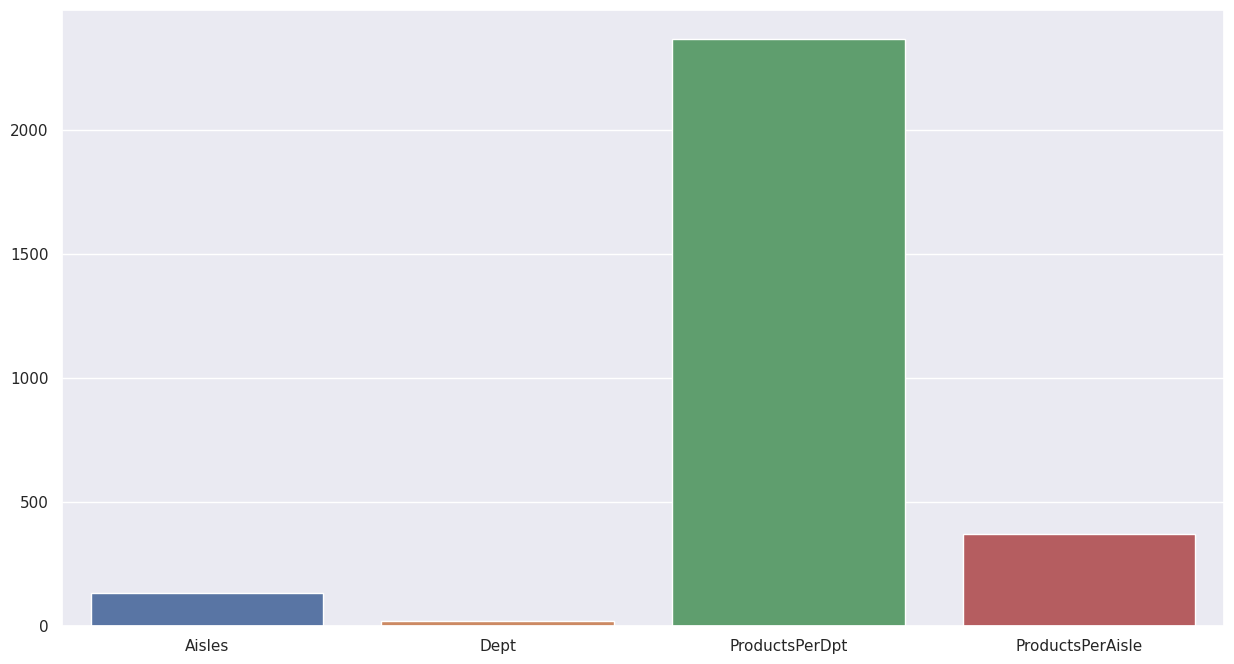

In [17]:
#This plot is based on manual calculations
sns.barplot(tableCounts)

Products or the Orders fact tables can be targeted for the data 
analysis. 

In [18]:
products_aisles = products.groupby('aisle_id').count()

In [19]:
products_aisles.sort_values(by='product_name',
                            ascending=False,inplace=True)
crowded_aisles = products_aisles[products_aisles.product_id > 800]

In [20]:
crowded_aisles.head(2)

,product_id,product_name,department_id
aisle_id,,,
100,1258,1258,1258
45,1246,1246,1246


In [21]:
crowded_aisles = pd.pivot_table(data=crowded_aisles,values=['product_id'],columns=['aisle_id'])

<AxesSubplot: xlabel='aisle_id'>

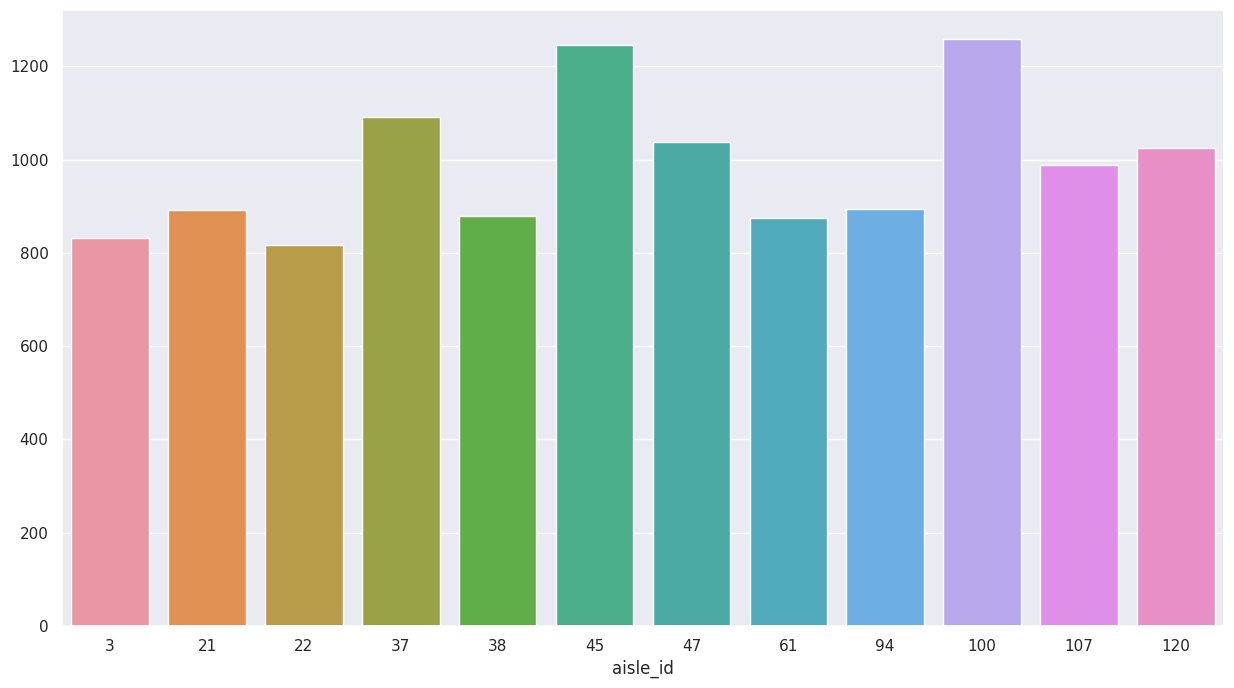

In [22]:
sns.barplot(crowded_aisles)

In [23]:
free_aisles = products_aisles[products_aisles.product_id < 200]
free_aisles.sort_values(by='product_id',ascending=False,inplace=True)
free_aisles = pd.pivot_table(data=free_aisles,values=['product_id'],columns=['aisle_id'])

<AxesSubplot: ylabel='aisle_id'>

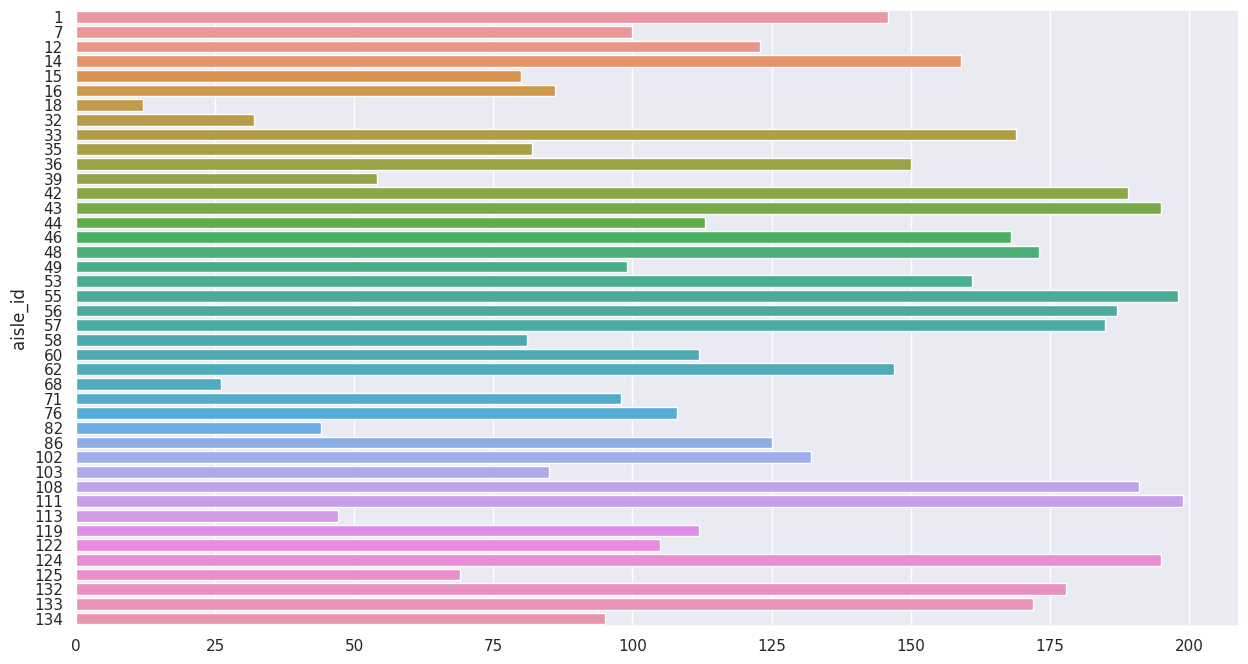

In [24]:
sns.barplot(free_aisles,orient='h')

In [25]:
department_counts = products.groupby('department_id').count()
department_counts.sort_values(by='product_id',
                              ascending=False, inplace=True)

<AxesSubplot: xlabel='department_id', ylabel='product_id'>

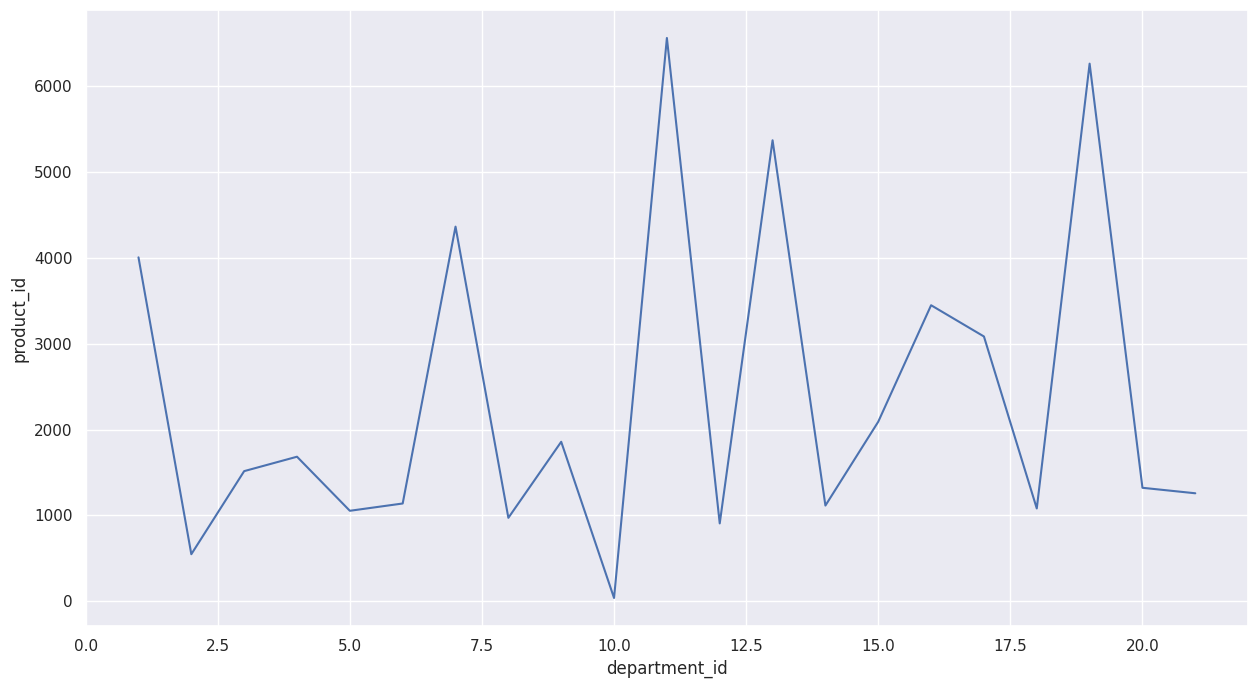

In [26]:
sns.lineplot(data=department_counts,x='department_id',
             y='product_id')

Shifting our focus to the orders dataset to understand 

- Which product is ordered the most

- which aisle has most orders

There are 3.4 million orders in the datasets. If you groupby the user_id, and count there are 206k+ users. 

Initially I thought that one of the user will have maximum orders. After analysing the data, found something different.

In [31]:
#There are 3.4 Million orders

order_user = orders[['order_id','user_id']].groupby('user_id').count()
order_user.sort_values(by='order_id',ascending=False,inplace=True)
order_user.head()

,order_id
user_id,
152340,100
185641,100
185524,100
81678,100
70922,100


In [32]:
# Okay... There are 206k+ customers

order_user.describe().head(2)

,order_id
count,206209.000000
mean,16.590367


Minimum and maximum number of orders done by a users in the dataset 
is varying between 4 and 100. 

Question is, why there are more customers who have made 100 orders?

<AxesSubplot: xlabel='order_id', ylabel='count'>

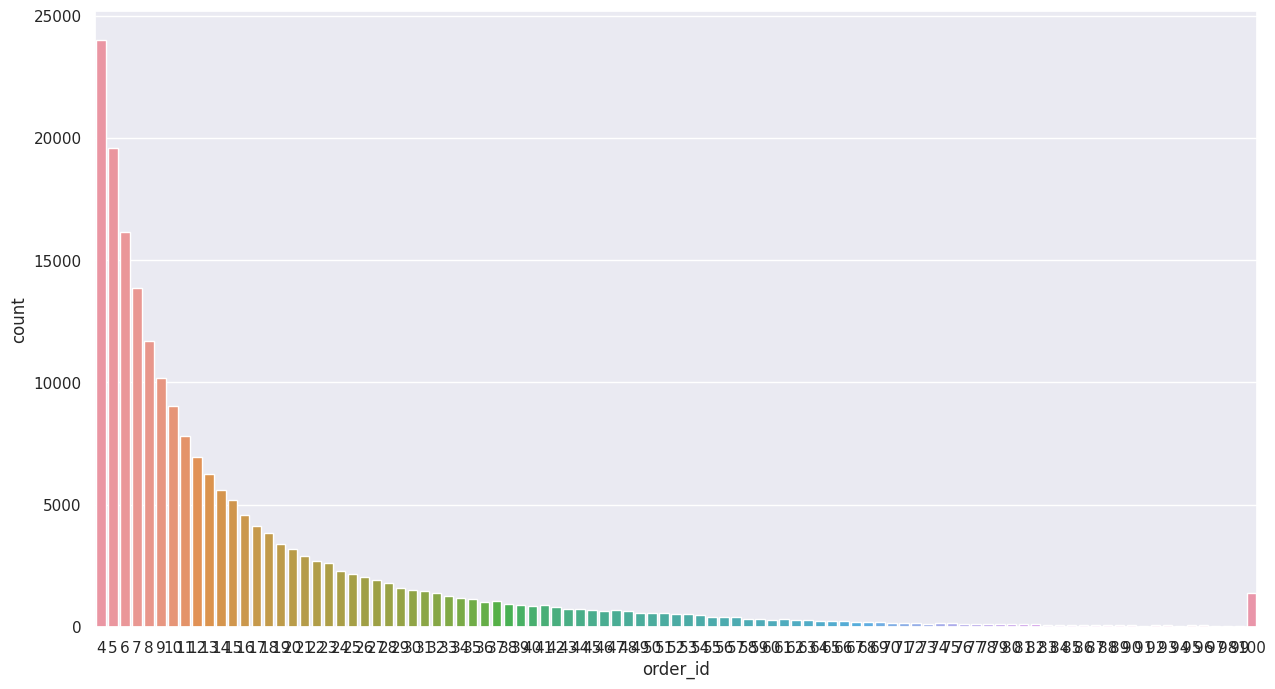

In [33]:
# Which user is ordering the most resulted in more than one user...

sns.countplot(order_user,x='order_id',width=0.8,orient='v')

In [34]:
# Lets start joining the orders and order_prior table, so the 
# product_id can be identified

ord